# Neural Bag of Words
<img src="imgs/01.nbow-intro.png" width="800" height="800" />

## Objectives
* In this tutorial a machine learning model will be created to perform sentiment analysis
  * a subset of text classification where the task is to detect if a given sentence is positive or negative
* The dataset used will be movie reviews from the IMDb dataset
* Topics like: tokenizer, vocabulary, embedding are introduced.

## Global and imports settings

In [1]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

## Internet Movie Database (IMDb) dataset
* Load dataset with `datasets` library
* Split in traing and test sets
* Take a look into the data:
  * is composed of test and label. Label ist 0 (positive feedback), 1 (negative feedback), and text

In [2]:
train_data_raw, test_data_raw = datasets.load_dataset("imdb", split=["train", "test"])
train_data_raw, test_data_raw

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [3]:
train_data_raw.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [4]:
train_data_raw[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Building input tokenizer
* Tokenizers split unstructured raw text into manageable units (words, subwords, or characters) that models can understand.
* word_tokenize is a function from NLTK's tokenize module that splits text into individual words and punctuation tokens. It converts a string of text into a list of tokens (e.g., words, commas, periods) for further NLP processing.

In [5]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
def get_tokens(text):
    return word_tokenize(text.lower())  # Tokenize and lowercase

print(get_tokens("Hello world! How are you doing today? I'm doing fantastic!"))
text = "Hello, Mr. Smith! Isn't NLP cool?"
print("Tokenizer", word_tokenize(text))  
print("Split", text.split())  



['hello', 'world', '!', 'how', 'are', 'you', 'doing', 'today', '?', 'i', "'m", 'doing', 'fantastic', '!']
Tokenizer ['Hello', ',', 'Mr.', 'Smith', '!', 'Is', "n't", 'NLP', 'cool', '?']
Split ['Hello,', 'Mr.', 'Smith!', "Isn't", 'NLP', 'cool?']


[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Applying Tokenizer: Mapping input text to tokens


In [6]:
max_length = 256

def tokenize_input(input, max_length):
    tokens = get_tokens(input["text"])[:max_length] # truncate text if too long
    return {"tokens": tokens}
    
train_data_tok = train_data_raw.map(
    tokenize_input, fn_kwargs={"max_length": max_length}
)
test_data_tok = test_data_raw.map(
    tokenize_input, fn_kwargs={"max_length": max_length}
)

* **tokenize_input** is a helper function that performs tokenization of text data from the dataset using the specified tokenizer. Its primary purposes are:
  * Tokenize Text: Converts raw text (from the dataset) into tokens
  * Truncating longer sequences to fit within max_length

In [7]:
train_data_tok

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [8]:
train_data_tok.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [9]:
train_data_tok[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967.',
 'i']

## Splitting into train, test, validation sets

In [10]:
test_size = 0.25
train_valid_data_splited = train_data_tok.train_test_split(test_size=test_size)
train_data_tok_splited = train_valid_data_splited["train"]
valid_data_tok_splited = train_valid_data_splited["test"]

In [11]:
len(train_data_tok_splited), len(valid_data_tok_splited), len(test_data_tok)

(18750, 6250, 25000)

### Why Have Both Validation and Test Datasets?
* Training set: self explained 
* Validation Set (Hyperparameter Tuning): Used during training to adjust model parameters (e.g., learning rate, regularization).
  * Helps prevent overfitting by evaluating performance on unseen data before final testing.
* Test Set (Final Model Evaluation): Used only once after training to measure real-world performance. Ensures the model generalizes well to completely new data.

## Building Vocabulary

* Neuronal networks don't work with words, but with numbers.
* The trick for NBow is to build a vocabulary, create embeddings words from vocabulary and pass embeddings as a proxy for original words.

In [12]:
from collections import Counter
# Building Vocabulary: Mapping word → unique ID
all_tokens = [token for example in train_data_tok for token in example["tokens"]]
word_counts = Counter(all_tokens)  # Count word occurrences

# Assign unique IDs (starting from 2 to reserve 0 for PAD, 1 for UNK)
min_freq = 5

word_counts_filtered = {x: count for x, count in word_counts.items() if count >= min_freq}

vocab = {word: idx + 2 for idx, word in enumerate(word_counts_filtered) }
pad_token_index = 0
unknown_token_index = 1
vocab["[PAD]"] = pad_token_index  # Padding token
vocab["[UNK]"] = unknown_token_index  # Unknown token

# Print vocabulary size
print(f"Vocabulary Size: {len(vocab)}")

# Print first 10 words in vocabulary
print(list(vocab.keys())[500:510])

Vocabulary Size: 25607
['themselves', 'jr.', 'how', 'filmmakers', 'hard', 'seems', 'awfully', 'sloppy', 'saw', 'glimpse']


* Collect all words in training set and their frequences
* Filter all words that have less min_freq hits in training set -> improve generalization
* Add special works for unknown words and padding

## Apply vocablurary to text tokens

In [13]:
def numericalize_example(example, vocab):
    unk_id = vocab.get("[UNK]", unknown_token_index)  # Get the UNK token ID (default: 1)
    ids = [vocab.get(token, unk_id) for token in example["tokens"]]  # Use UNK for unknown words
    return {"ids": ids}

In [14]:
train_data_num = train_data_tok_splited.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data_num = valid_data_tok_splited.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data_num = test_data_tok.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [15]:
# Print the first example before and after tokenization
original_text = train_data_num[0]["text"]  # Get original text
tokenized_ids = train_data_num[0]["ids"]  # Get tokenized input IDs

vocab_inv = {v: k for k, v in vocab.items()}  # Invert mapping
tokenized_text = [vocab_inv.get(token, "[UNK]") for token in tokenized_ids]
print(f"Original Text:\n{original_text}\n")
print(f"Tokens:\n{tokenized_text}\n")
print(f"Token IDS:\n{tokenized_ids}\n")

Original Text:
Look, this is quite possibly one of the best movies America has to offer the rest of the world. To hate this movie is to hate freedom itself. I remember that the early 80's were a time of uncertainty. The economy was weak, communism threatened us all, and nuclear destruction was almost a certainty. Out of that confusion came a hero, Stroker Ace. Ned Beatty's performance in this movie showed he was never again to be type cast as a one dimensional victim in the wilderness. His triumph is an inspiration to all. The on-screen chemistry between Burt and Loni draws obvious comparisons to Brad and Jennifer. Jim Nabors is a poet. Go see this movie tonight!

Tokens:
['look', ',', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the', 'best', 'movies', 'america', 'has', 'to', 'offer', 'the', 'rest', 'of', 'the', 'world', '.', 'to', 'hate', 'this', 'movie', 'is', 'to', 'hate', 'freedom', 'itself', '.', 'i', 'remember', 'that', 'the', 'early', '80', "'s", 'were', 'a', 'time', 'of', 

In [16]:
train_data_tensor = train_data_num.with_format(type="torch", columns=["ids", "label"])
valid_data_tensor = valid_data_num.with_format(type="torch", columns=["ids", "label"])
test_data_tensor = test_data_num.with_format(type="torch", columns=["ids", "label"])

In [17]:
train_data_tensor[0]

{'label': tensor(1),
 'ids': tensor([ 1880,    37,    35,    57,   715,  1615,   163,    10,    12,   987,
           205,  2205,   107,    33,   185,    12,   703,    10,    12,   332,
            74,    33,  3078,    35,   350,    57,    33,  3078,  5886,  2099,
            74,     2,  1264,    14,    12,   366,   805,   127,   388,    40,
           304,    10, 20708,    74,    12, 16539,    18,  1891,    37,  6778,
         11265,   704,    11,    37,    94, 11882, 12090,    18,   582,    40,
         12358,    74,   306,    10,    14,  2892,  2554,    40,  1938,    37,
          9236,  9237,    74,  1911,  5926,   127,  1509,    21,    35,   350,
           733,   555,    18,   478,   561,    33,   167,   272,   802,    91,
            40,   163,  3309,  1894,    21,    12, 12840,    74,   151,  7807,
            57,   175,  1724,    33,    11,    74,    12,  4085,  3630,    98,
          4664,    94,  9267,  7683,   234, 11340,    33,   918,    94,  3931,
            74,  4716,  

## Building dataloader

In [18]:
def get_collate_fn(pad_token_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        # Pad a list of variable length Tensors with padding_value.
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_token_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

* The get_collate_fn function defines a custom collation function for PyTorch's DataLoader that processes batches of variable-length sequences. Here's a breakdown:
* Purpose:
  * Handles batches where input sequences have different lengths by:
  * Padding sequences to match the longest sequence in the batch
  * Properly stacking labels

get_data_loader creates a PyTorch DataLoader configured with a custom collation function for handling variable-length sequences. It wraps PyTorch's standard DataLoader while incorporating the padding logic from the get_collate_fn function.

In [19]:
def get_data_loader(dataset, batch_size, pad_token_index, shuffle=False):
    collate_fn = get_collate_fn(pad_token_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [20]:
batch_size = 512

train_data_loader = get_data_loader(train_data_tensor, batch_size, pad_token_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data_tensor, batch_size, pad_token_index)
test_data_loader = get_data_loader(test_data_tensor, batch_size, pad_token_index)

## Building neuronal model with PyTorch

<img src="imgs/nbow_model.png" width="800" height="800" />
A simple neural network for text classification that treats input text as an unordered set of words (bag-of-words representation).

In [21]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_token_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

### Embedding Layer
* Maps token IDs → dense vectors

### Mean Pooling
* Averages word embeddings along sequence dimension
* Converts [batch_size, seq_len, emb_dim] → [batch_size, emb_dim]
* Captures overall document semantics

### Linear Classifier
* Maps pooled embedding → class logits
* Output_dim: Number of classes (e.g., 2 for binary classification)

In [22]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data_tensor.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_token_index)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 7,682,702 trainable parameters


### Download pre-trained embedding
* Code just downloads archive and unarchives desired dimensionality.
* Pretrained embedding capture simularities, e.g. if words are similar then cosine is -> 1
```
             king    france  computer
king     1.000000  0.345671  0.123456
queen    0.856734  0.234567  0.098765
prince   0.823456  0.287654  0.087654
...          ...       ...       ...
france   0.345671  1.000000  0.056789
germany  0.301234  0.912345  0.043210
paris    0.287654  0.876543  0.065432
...          ...       ...       ...
computer 0.123456  0.056789  1.000000
software 0.098765  0.043210  0.876543
keyboard 0.087654  0.032109  0.812345
````

In [24]:
import os
import requests
import zipfile
import os
import requests
import zipfile

def download_glove(dim=100, save_dir="glove"):
    assert dim in [50, 100, 200, 300], "Invalid dimension. Must be one of [50, 100, 200, 300]"
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    zip_path = os.path.join(save_dir, "glove.6B.zip")
    target_file = f"glove.6B.{dim}d.txt"
    target_path = os.path.join(save_dir, target_file)

    os.makedirs(save_dir, exist_ok=True)

    if not os.path.exists(target_path):
        if not os.path.exists(zip_path):
            print("Downloading GloVe embeddings...")
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))
            with open(zip_path, "wb") as f, tqdm(
                desc=zip_path,
                total=total_size,
                unit="B",
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    f.write(data)
                    bar.update(len(data))

        print("Extracting...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extract(target_file, path=save_dir)

    print(f"GloVe {dim}d embedding ready at: {target_path}")
    return target_path

# Example usage:
glove_path = download_glove(dim=embedding_dim)

GloVe 300d embedding ready at: glove/glove.6B.300d.txt


### Load embedding matrix into the model

In [25]:
# Convert numerical token IDs back into words (tokens).
# vocab = { "[PAD]": 0,"[UNK]": 1, "the": 2, "cat": 3, "sat": 4 }
# itos = {0: "[PAD]", 1: "[UNK]", 2: "the", 3: "cat", 4: "sat" }
itos = {idx: token for token, idx in vocab.items()}

# Load GloVe embeddings from file system
def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  # First word is the token
            vector = np.asarray(values[1:], dtype="float32")  # Remaining values are the embedding
            embeddings[word] = vector
    return embeddings

# Path to GloVe file (adjust the path to your local file)
# glove_path = "glove.6B.300d.txt"  # Use 300-dimensional GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_path)

avg_glove_embedding = np.mean(np.array(list(glove_embeddings.values())), axis=0)
# Create an embedding matrix for the vocabulary
embedding_matrix = np.zeros((len(itos), embedding_dim))

for idx, token in enumerate(itos):
    if token in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[token]
    else:
        embedding_matrix[idx] = avg_glove_embedding  # init for unknown tokens

# Convert embedding matrix to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: torch.Size([25607, 300])


In [26]:
# Convert the embedding matrix to a PyTorch tensor
embedding_matrix = embedding_matrix.clone().detach().float()

# Assign to the model's embedding layer
model.embedding.weight.data.copy_(embedding_matrix)
print("GloVe embeddings loaded into the model.")

GloVe embeddings loaded into the model.


## Building Training Pipeline

In [27]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

Adaptive Learning Rates (ADAM):
* Adam automatically adjusts learning rates for each parameter (using momentum and adaptive scaling), which:
* Works well with sparse gradients (common in NLP)
* Eliminates need for manual learning rate scheduling
* Outperforms SGD for most NLP tasks

Output Layer Behavior:
* The final layer produces raw logits (unnormalized scores)
* This is the required input format for nn.CrossEntropyLoss
* The loss function internally applies LogSoftmax + NLLLoss
```
# Equivalent to:
log_probs = F.log_softmax(model(inputs), dim=1)
loss = F.nll_loss(log_probs, labels)
```

Standard Practice:
* PyTorch classification models typically output raw logits
* This pattern is used in official tutorials and production code
* Simplifies the model architecture

### Training step

* *tqdm*: use tqdm to display a real-time progress bar during training, which provides valuable feedback about training progress, estimated time remaining, and batch processing speed. While you can use enumerate, tqdm offers significant usability advantages.

In [28]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

### Test step

In [29]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

## Model in the loop

In [30]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [31]:
import collections

n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 23.13it/s]


epoch: 0
train_loss: 0.688, train_acc: 0.566
valid_loss: 0.679, valid_acc: 0.643


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 21.26it/s]


epoch: 1
train_loss: 0.659, train_acc: 0.738
valid_loss: 0.639, valid_acc: 0.746


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 19.15it/s]


epoch: 2
train_loss: 0.600, train_acc: 0.772
valid_loss: 0.572, valid_acc: 0.773


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 23.26it/s]


epoch: 3
train_loss: 0.525, train_acc: 0.808
valid_loss: 0.505, valid_acc: 0.810


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 20.57it/s]


epoch: 4
train_loss: 0.454, train_acc: 0.840
valid_loss: 0.450, valid_acc: 0.832


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 23.04it/s]


epoch: 5
train_loss: 0.396, train_acc: 0.865
valid_loss: 0.408, valid_acc: 0.849


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 21.27it/s]


epoch: 6
train_loss: 0.352, train_acc: 0.882
valid_loss: 0.379, valid_acc: 0.858


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 20.78it/s]


epoch: 7
train_loss: 0.317, train_acc: 0.895
valid_loss: 0.357, valid_acc: 0.863


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 22.02it/s]


epoch: 8
train_loss: 0.290, train_acc: 0.903
valid_loss: 0.340, valid_acc: 0.869


evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 22.70it/s]

epoch: 9
train_loss: 0.266, train_acc: 0.912
valid_loss: 0.328, valid_acc: 0.872


### Performance during training

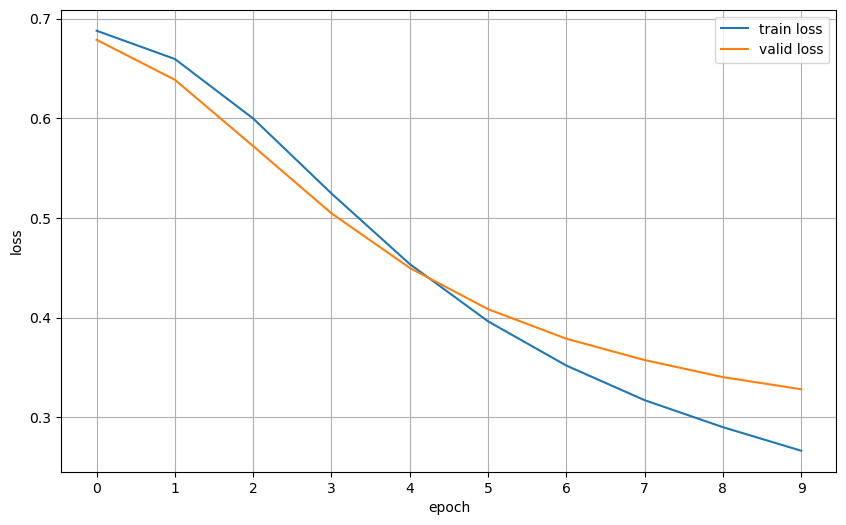

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

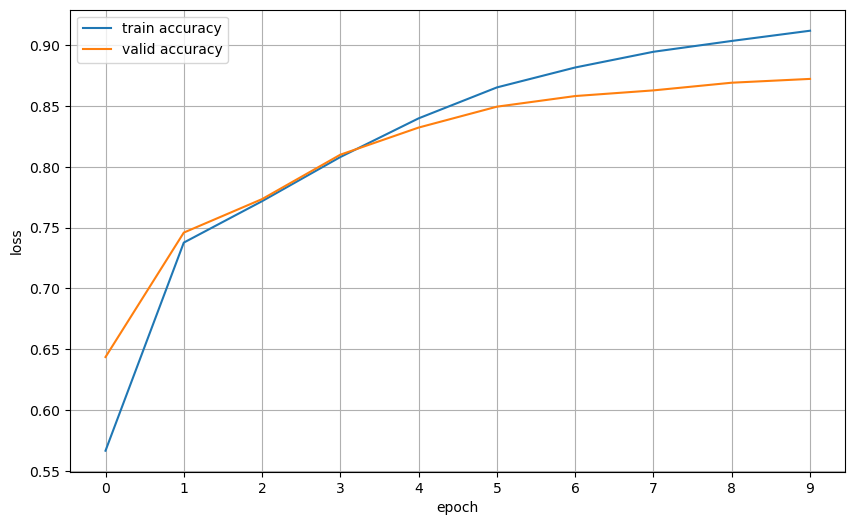

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

## Usage of trained model

In [34]:
model.load_state_dict(torch.load("nbow.pt", weights_only=True))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.90it/s]


In [35]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.361, test_acc: 0.852


In [36]:
def predict_sentiment(text, model, vocab, device):
    tokens = get_tokens(text)
    ids = [vocab.get(token, vocab.get("[UNK]", 0)) for token in tokens]  # ✅ Correct

    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()

    sentiment = "pos" if predicted_class == 1 else "neg"
    print(f"Sentiment: {sentiment} ({predicted_probability:.4f})")

    return predicted_class, predicted_probability


In [37]:
text = "This film is terrible!"

predict_sentiment(text, model, vocab, device)

Sentiment: neg (1.0000)


(0, 0.9999643564224243)

In [38]:
text = "This film is great!"

predict_sentiment(text, model, vocab, device)

Sentiment: pos (1.0000)


(1, 0.9999986886978149)

In [39]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, vocab, device)

Sentiment: pos (0.7622)


(1, 0.7622362375259399)

In [40]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, vocab, device)

Sentiment: pos (0.7622)


(1, 0.7622362375259399)